In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from dataclasses import dataclass

sns.set_theme()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['grid.alpha'] = 0.3

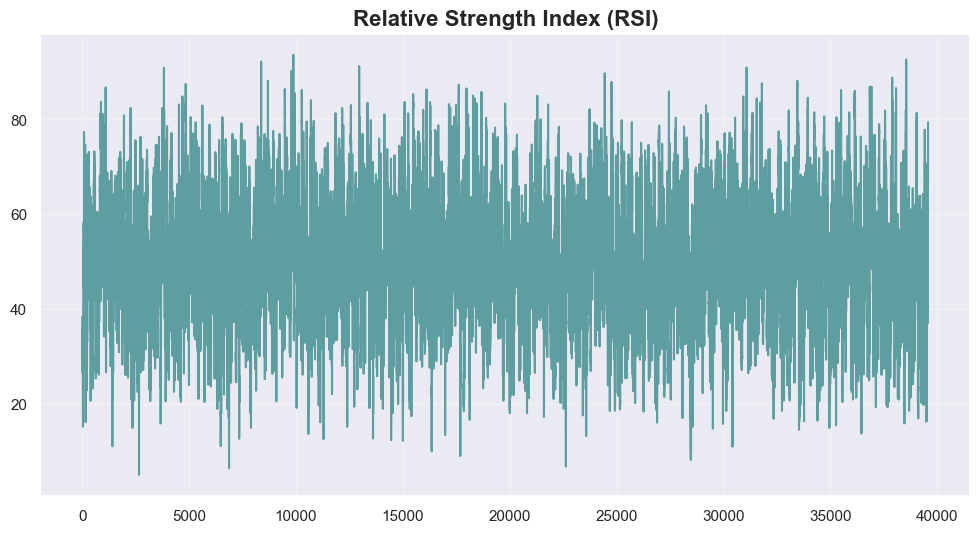

In [34]:
data = pd.read_csv('../data/aapl_5m_train.csv')

rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=15)

data['rsi'] = rsi_indicator.rsi()
data['buy_signal'] = data['rsi'] < 16
data['sell_signal'] = data['rsi'] > 80

data = data.dropna()

plt.figure()
plt.plot(data['rsi'], label='RSI', color='cadetblue')
plt.title('Relative Strength Index (RSI)')
plt.show()

# Supuestos

+ Comisión = 0.125%
+ No hay impuestos
+ No apalancamiento
+ Cuenta Margen = 50%
+ Capital = 1,000,000
+ N Shares = 50
+ Stop Loss / Take Profit = 6%
+ Trades at Close
+ Borrow Rate 0.25%

In [35]:
COM = 0.125/100

#DOF (Grados de libertad)
STOP_LOSS = 0.1
TAKE_PROFIT = 0.1
N_SHARES = 500

capital = 1_000_000

margin_account = 50/100
BORROW_RATE=0.25/100 #Actual borrow for Apple stock

In [36]:
@dataclass
class Position:
    """
    Represents a trading position.
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    time: str

def get_portfolio_value(capital, long_positions, current_price, n_shares):
    # Long positions are valued at current market price
    value = capital
    value += len(long_positions) * n_shares * current_price

    return value

Final Capital: 1,358,884.47


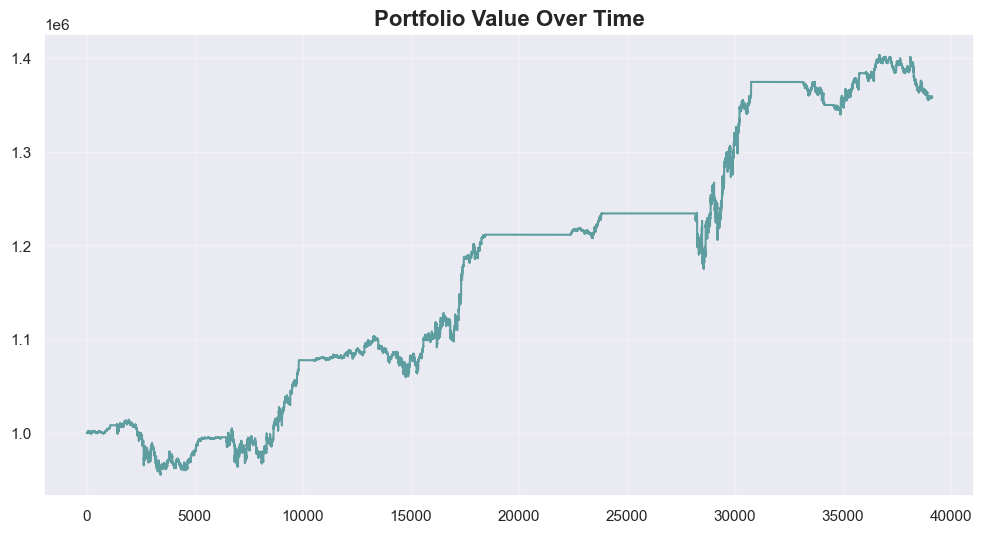

In [37]:
active_long_positions: list[Position] = []
portfolio_values = []

for i, row in data.iterrows():
    # -- LONG ACTIVE ORDERS -- #
    for position in active_long_positions.copy():
        # Stop Loss or take profit Check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1-COM)
            #Remove position from active pos
            active_long_positions.remove(position)

    # -- LONG -- #
    # Check Signal
    if row.buy_signal:
        cost = row.Close * N_SHARES * (1 + COM)
        # Do we have enough capital cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(
                ticker='AAPL',
                n_shares=N_SHARES,
                price=row['Close'],
                sl=row['Close'] * (1 - STOP_LOSS),
                tp=row['Close'] * (1 + TAKE_PROFIT),
                time=row['Datetime']
            )
            active_long_positions.append(pos)

    portfolio_values.append(get_portfolio_value(capital, active_long_positions, row.Close, N_SHARES))

#At the end of the backtesting, we should close all active positions
capital += row.Close * len(active_long_positions)*N_SHARES * (1-COM)
active_long_positions = []

print(f'Final Capital: {capital:,.2f}')
plt.figure()
plt.plot(portfolio_values, label='Portfolio Value', color='cadetblue')
plt.title('Portfolio Value Over Time')
plt.show()